In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
from numpy.linalg import matrix_rank
from scipy.linalg import null_space, inv
import random

In [2]:
im1 = cv2.imread('data/cube1.jpg')
im2 = cv2.imread('data/cube2.jpg')
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

data = loadmat('data/compEx2data.mat')
Xmodel = data['Xmodel']
startind = data['startind']
endind = data['endind']

camera_matrices = np.load("camera_matrices.npz")
P1 = camera_matrices['P1']
P2 = camera_matrices['P2']
K1 = camera_matrices['K1']
K2 = camera_matrices['K2']
K_inv1 = inv(K1)
K_inv2 = inv(K2)

x1_x2 = np.load("x1_x2.npz")
x1 = x1_x2['x1']
x2 = x1_x2['x2']
x1 = x1.T  
x2 = x2.T  

In [3]:
def hom(matrix):
    matrix = np.array(matrix)
    ones_row = np.ones((1, matrix.shape[1]))
    homogeneous_matrix = np.vstack((matrix, ones_row))
    return homogeneous_matrix

def triangulate_3D_point_DLT(P1, P2, x1, x2):
    
    A = np.zeros((4, 4))
    
    A[0] = x1[0] * P1[2] - P1[0]
    A[1] = x1[1] * P1[2] - P1[1]
    A[2] = x2[0] * P2[2] - P2[0]
    A[3] = x2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]  
    
    return X / X[-1]

def triangulate_all_points(P1, P2, x1, x2, K_inv1=None, K_inv2=None):
    if K_inv1 is not None and K_inv2 is not None:
        x1_hom = hom(x1)
        x2_hom = hom(x2)
        x1 = K_inv1 @ x1_hom  
        x2 = K_inv2 @ x2_hom
        P1 = K_inv1 @ P1
        P2 = K_inv2 @ P2

    X = np.zeros((4, x1.shape[1]))  

    for i in range(x1.shape[1]):
        X[:, i] = triangulate_3D_point_DLT(P1, P2, x1[:, i], x2[:, i])

    return X

X = triangulate_all_points(P1, P2, x1, x2)

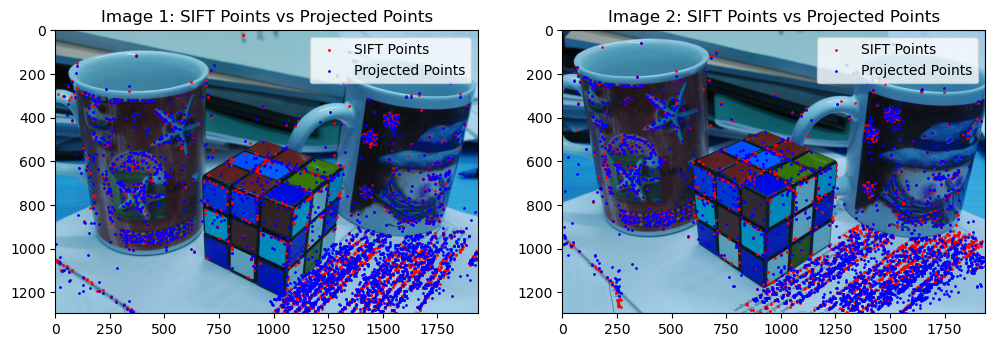

In [4]:
def project_2D_points(P, X):
    x_proj = P @ X 
    x_proj = x_proj[:2, :] / x_proj[2, :]
    return x_proj  


x_proj1 = project_2D_points(P1, X)
x_proj2 = project_2D_points(P2, X)


def plot_comparison(im1, im2, x1, x2, x_proj1, x_proj2,path):
  
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.scatter(x1[0, :], x1[1, :], color='r', label='SIFT Points', s=1)
    plt.scatter(x_proj1[0, :], x_proj1[1, :], color='b', label='Projected Points', s=1)
    plt.legend(loc='upper right')
    plt.title('Image 1: SIFT Points vs Projected Points')

    plt.xlim(0,im1.shape[1])
    plt.ylim(im1.shape[0],0)

    plt.subplot(1, 2, 2)
    plt.imshow(im2)
    plt.scatter(x2[0, :], x2[1, :], color='r', label='SIFT Points', s=1)
    plt.scatter(x_proj2[0, :], x_proj2[1, :], color='b', label='Projected Points',s=1)
    plt.legend(loc='upper right')
    plt.title('Image 2: SIFT Points vs Projected Points')

    plt.xlim(0,im2.shape[1])
    plt.ylim(im2.shape[0],0)

    plt.savefig(path)
    plt.show()

plot_comparison(im1, im2, x1, x2, x_proj1, x_proj2,'figs/not_norm.png')


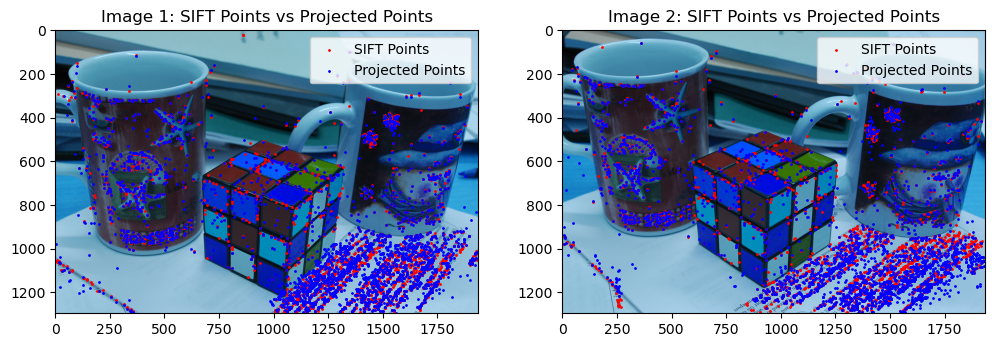

In [5]:
X_norm =  triangulate_all_points(P1, P2, x1, x2, K_inv1,K_inv2)
x_proj1_norm = project_2D_points(P1, X_norm)
x_proj2_norm = project_2D_points(P2, X_norm)
plot_comparison(im1, im2, x1, x2, x_proj1_norm, x_proj2_norm, 'figs/norm.png')

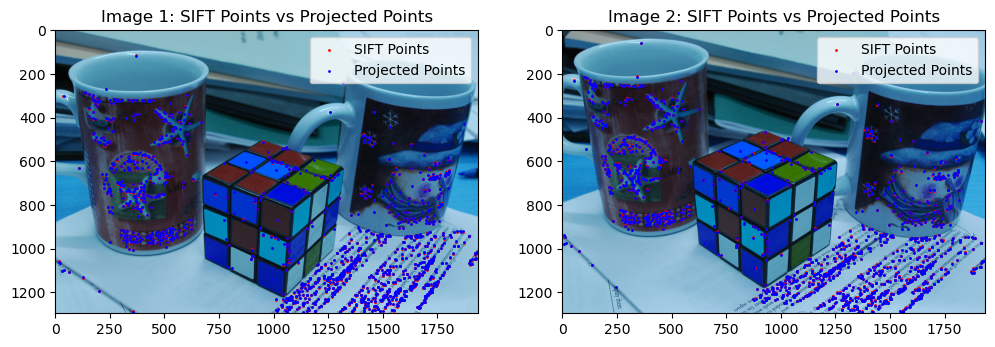

In [31]:
good_points = (np.sqrt(np.sum((x1 - x_proj1[:2, :])**2, axis=0)) < 3) & (np.sqrt(np.sum((x2 - x_proj2[:2, :])**2, axis=0)) < 3)
x1_filtered = x1[:,good_points]
x2_filtered = x2[:,good_points]
x_proj1_filtered = x_proj1_norm[:, good_points]
x_proj2_filtered = x_proj2_norm[:, good_points]

plot_comparison(im1, im2, x1_filtered, x2_filtered, x_proj1_filtered, x_proj2_filtered,'figs/goodpoints.png')

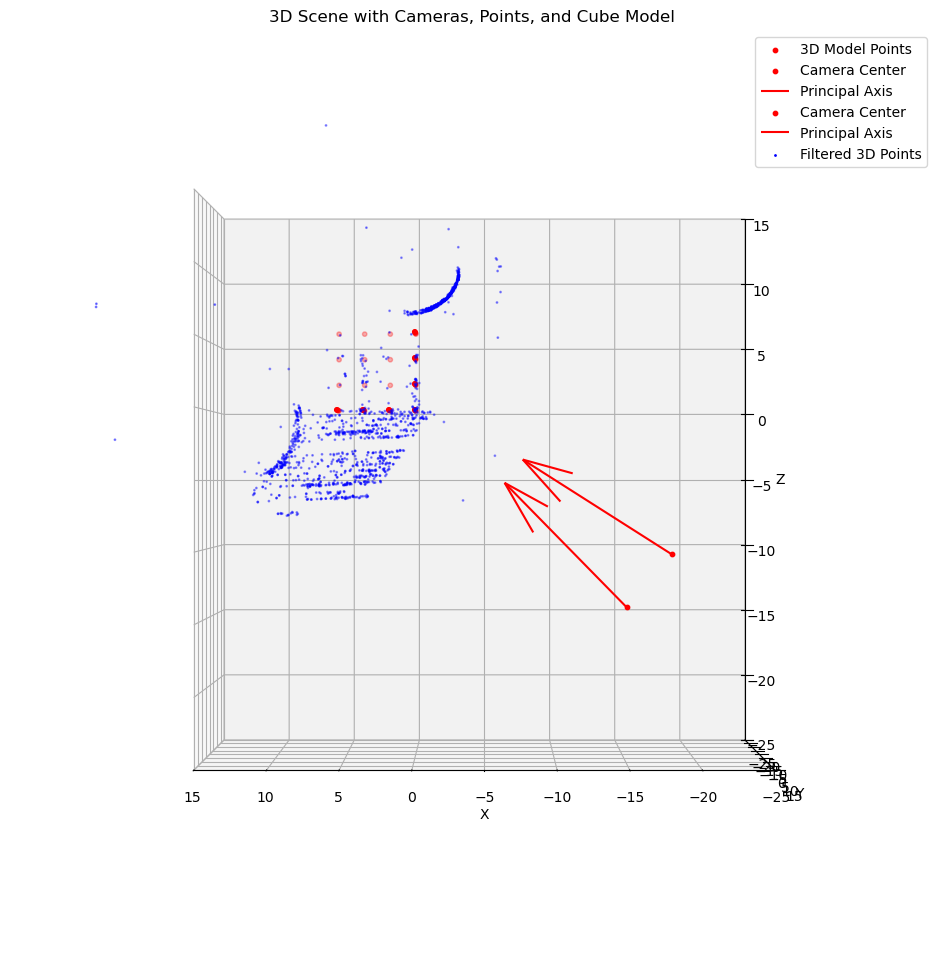

In [32]:
def plot_cams(P_list, ax):

    for P in P_list:
        c = null_space(P).flatten()
        c /= c[-1]
        v = P[2, :3]
        color = random.choice(["orange", "red", "green","blue","yellow"])
        ax.scatter(c[0], c[1], c[2], color=color, s=10, label="Camera Center")
        ax.quiver(c[0], c[1], c[2], v[0], v[1], v[2], color=color, length=1000, linewidth=1.5, label="Principal Axis")


def plot_3D_scene_with_cameras(X,P_list, Xmodel=None, startind=None, endind=None):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xmodel[0], Xmodel[1], Xmodel[2], color='red', s=10, label="3D Model Points")

    plot_cams(P_list, ax)

    ax.scatter(X_3D[0], X_3D[1], X_3D[2], color='b', s=1, label='Filtered 3D Points')

    ax.set_xlim(-25,15)
    ax.set_ylim(-25,15)
    ax.set_zlim(-25,15)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.legend()
    plt.title("3D Scene with Cameras, Points, and Cube Model")
    ax.view_init(elev=0, azim=90)
    plt.savefig("figs/aa.png")
    plt.show()

P_list = [P1, P2]
X_3D = X_norm[:,good_points]
plot_3D_scene_with_cameras(X_3D, P_list, Xmodel=Xmodel)
